# Reference script helping to understand functions, parcellations, surfaces, meshes

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
from math import isnan

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir = '/data/p_02667/sex_diff_gradients/results/'

## Set-up

### Loading the data

In [3]:
## loading demographics information

# GSP
GSP_demographics = pd.read_csv(resdir+'GSP/demographics_cleaned.csv')

# HCP
HCP_demographics = pd.read_csv(resdir+'HCP/merged_demographics_cleaned.csv')



## loading mean gradients

# GSP
GSP_mean_grad = pd.read_csv(resdir+'GSP/mean_gradient_eigenvalues.csv')

# labeling the gradients whereby for GSP: unimodal-heteromodal (G2), visual-sensorimotor (G1)
GSP_mean_grad.columns = ['visual-sensorimotor', 'unimodal-heteromodal', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']


# HCP
HCP_mean_grad = pd.read_csv(resdir+'HCP/mean_gradient_eigenvalues.csv')  

# labeling the gradients whereby for HCP: unimodal-heteromodal (G1), visual-sensorimotor (G2)
HCP_mean_grad.columns = ['unimodal-heteromodal', 'visual-sensorimotor', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']



## loading full gradient arrays

# GSP
GSP_array_aligned_G1 = pd.read_csv(resdir+'GSP/array_aligned_G1.csv')
GSP_array_aligned_G2 = pd.read_csv(resdir+'GSP/array_aligned_G2.csv')
GSP_array_aligned_G3 = pd.read_csv(resdir+'GSP/array_aligned_G3.csv')

# HCP
HCP_array_aligned_G1 = pd.read_csv(resdir+'HCP/array_aligned_G1.csv')
HCP_array_aligned_G2 = pd.read_csv(resdir+'HCP/array_aligned_G2.csv')
HCP_array_aligned_G3 = pd.read_csv(resdir+'HCP/array_aligned_G3.csv')



## loading SLM (model including sex, age and ICV for sex testing for sex differences) containing R results

# GSP
GSP_slm_G1 = pd.read_csv(resdir+'GSP/R_lm_G1_sex_age_icv_res.csv')  # visual - sensorimotor
GSP_slm_G2 = pd.read_csv(resdir+'GSP/R_lm_G2_sex_age_icv_res.csv')  # unimodal - heteromodal
GSP_slm_G3 = pd.read_csv(resdir+'GSP/R_lm_G3_sex_age_icv_res.csv')  

# HCP
HCP_slm_G1 = pd.read_csv(resdir+'HCP/R_lm_G1_sex_age_icv_res.csv')  # unimodal - heteromodal
HCP_slm_G2 = pd.read_csv(resdir+'HCP/R_lm_G2_sex_age_icv_res.csv')  # visual - sensorimotor
HCP_slm_G3 = pd.read_csv(resdir+'HCP/R_lm_G3_sex_age_icv_res.csv')  

## Fetch fsaverage parcellation (20484 vertices) coded for Schaefer 400 parcels

In [3]:
# fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

### Noting that schaefer_400_fs5 has labels that go from 0-400 (instead of 1-400 corresponding to the 400 Schaefer parcels) -> 0 should correspond to midline

In [5]:
print(min(schaefer_400_fs5)); print(max(schaefer_400_fs5))

0
400


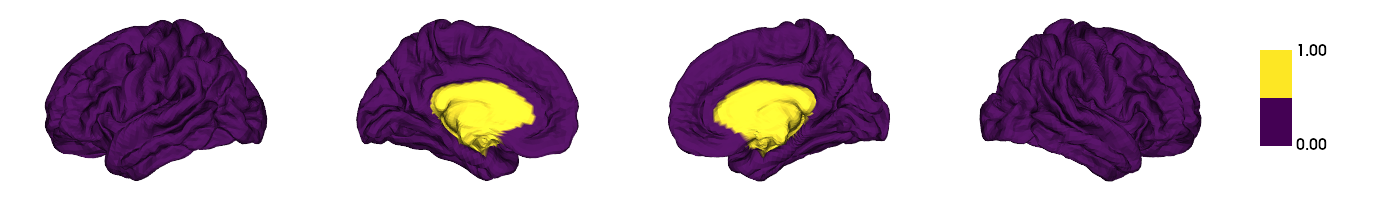

In [7]:
# testing whether the fsaverage vertices labeled 0 correspond to the midline
midline_mask = (schaefer_400_fs5 == 0)


# need to plot right and left hemispheres with fsaverage mesh (instead of loading conte69) because what I am testing is in fsaverage5 (20484 vertices) unlike conte69 (64984 vertices)
mesh_paths = {
   'L': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_left'],
   'R': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_right']
}
surf_lh = brainspace.mesh.mesh_io.read_surface(mesh_paths['L'])
surf_rh = brainspace.mesh.mesh_io.read_surface(mesh_paths['R'])



plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = midline_mask, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = 'viridis', 
    color_bar = True, 
    #color_range = color_range_t,
    nan_color = (0.7, 0.7, 0.7, 1),
    #label_text = ["overlap of significant sex differences"],
    zoom = 1.45)

plotted_hemispheres

## Schaefer400 vs fsaverage5 plotting

Example: unimodal-heteromodal gradient eigenvalues

### Data

In [18]:
GSP_mean_grad = pd.read_csv(resdir+'GSP/mean_gradient_eigenvalues.csv')

# labeling the gradients whereby for GSP: unimodal-heteromodal (G2), visual-sensorimotor (G1)
GSP_mean_grad.columns = ['visual-sensorimotor', 'unimodal-heteromodal', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']

print(f"Length of Schaefer400 data: {len(GSP_mean_grad['unimodal-heteromodal'])}")

Length of Schaefer400 data: 400


Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [19]:
GSP_fs5_eigenvalues_unimodal_heteromodal = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    if schaefer_400_fs5[i] == 0:  # corresponds to the midline
        # append to the lists of fs5_tvals: 0
        GSP_fs5_eigenvalues_unimodal_heteromodal.append(0)
        
    else:
        # append to the lists of fs5_tvals: the unimodal-heteromodal gradient eigenvalue of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
        GSP_fs5_eigenvalues_unimodal_heteromodal.append(GSP_mean_grad.loc[:, 'unimodal-heteromodal'][schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_eigenvalues_unimodal_heteromodal[GSP_fs5_eigenvalues_unimodal_heteromodal == 0] = np.nan

# transform list into array
GSP_fs5_eigenvalues_unimodal_heteromodal = np.asarray(GSP_fs5_eigenvalues_unimodal_heteromodal)


print(f"Length of fsaverage5 data: {len(GSP_fs5_eigenvalues_unimodal_heteromodal)}")

Length of fsaverage5 data: 20484


### Schaefer 400 (400 parcels)

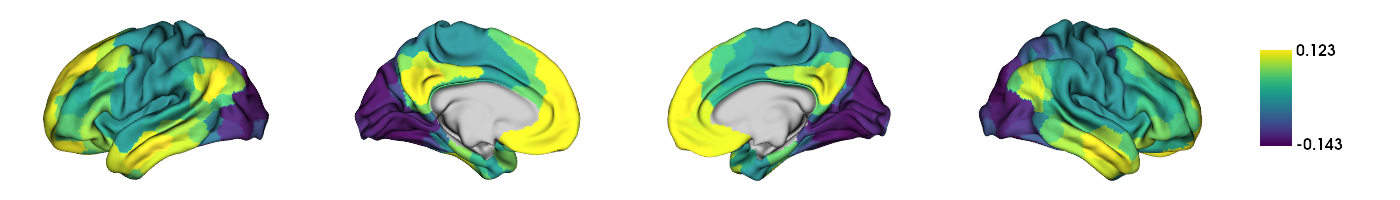

In [34]:
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)  # fetch the fsaverage parcellation labeling each of conte69(?)'s 64984 vertices with its corresponding Schaefer parcel; len(labeling) = 64984 
surf_lh, surf_rh = load_conte69()
mask = labeling != 0  # do not consider 0 labels which correspond to the midline; len(mask) = 64984

# need to map the 400 Schaefer parcel values to 64984 vertices (because that is size corresponding to the surfaces we are projecting onto (conte69 surf_lh and surf_rh)
mapped_to_labels = map_to_labels(source_val = np.array(GSP_mean_grad['unimodal-heteromodal']), target_lab = labeling, mask = mask, fill = np.nan) 

plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = mapped_to_labels, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = 'viridis', 
    color_bar = True, 
    #color_range = color_range_t,
    nan_color = (0.7, 0.7, 0.7, 1),
    #label_text = [""],
    zoom = 1.45)

plotted_hemispheres

### fsaverage5 (20484 vertices)

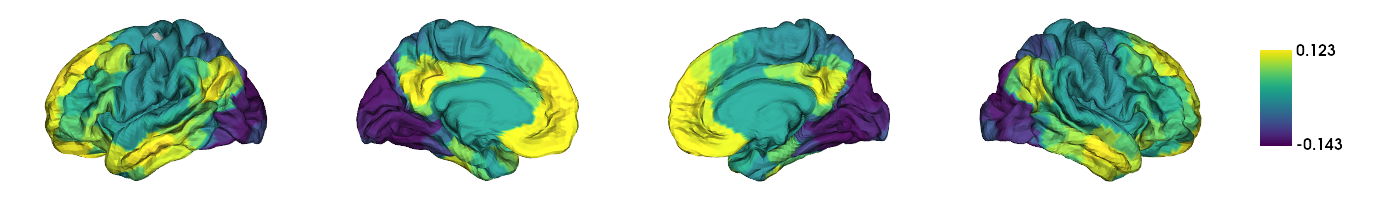

In [32]:
# need to plot right and left hemispheres with fsaverage mesh (instead of loading conte69) because what I am testing is in fsaverage5 (already in format: 20484 vertices) unlike conte69 (64984 vertices)
mesh_paths = {
   'L': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_left'],
   'R': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_right']
}
surf_lh = brainspace.mesh.mesh_io.read_surface(mesh_paths['L'])
surf_rh = brainspace.mesh.mesh_io.read_surface(mesh_paths['R'])


plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = GSP_fs5_eigenvalues_unimodal_heteromodal, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = 'viridis', 
    color_bar = True, 
    #color_range = color_range_t,
    nan_color = (0.7, 0.7, 0.7, 1),
    #label_text = [""],
    zoom = 1.45)

plotted_hemispheres

## Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)

In [35]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


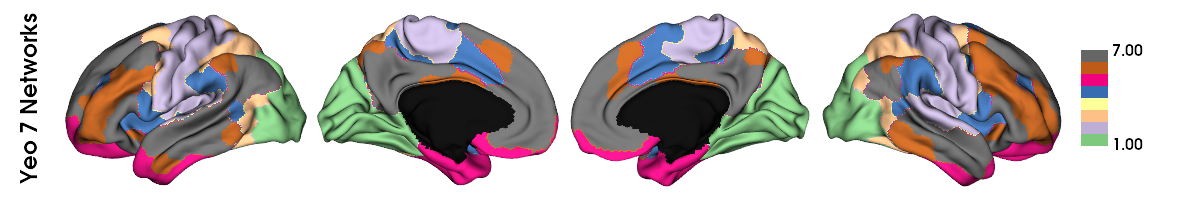

In [36]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)